In [2]:
import numpy as np
import scipy.sparse as sparse
import math
import matplotlib.pyplot as plt
from mec import make_circle
from Grid import Grid
import copy
# import seaborn as sns
# import lmfit
from itertools import chain
from scipy import integrate
import random
import pandas as pd
from collections import Counter

6.309573444801933 5.807620410262125 5.884353764298863


(array([  6.,  24.,  42., 107., 164., 241., 221., 127.,  51.,  17.]),
 array([2.85611914, 3.38489261, 3.91366608, 4.44243955, 4.97121302,
        5.49998649, 6.02875996, 6.55753343, 7.0863069 , 7.61508037,
        8.14385384]),
 <BarContainer object of 10 artists>)

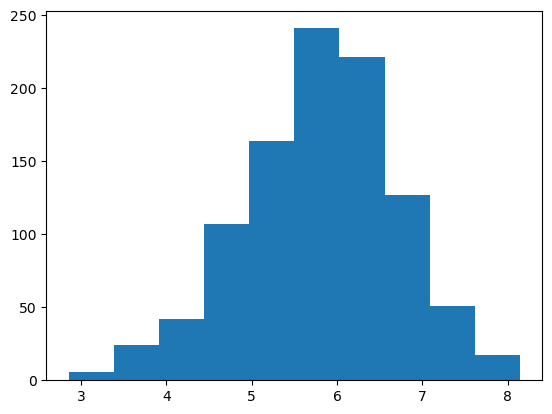

In [3]:
def draw_circle(M, gamma, k, num_iters):
    rs = []
    r = M**gamma
    for p in np.random.uniform(low=-r, high=r, size=(num_iters,k,2)):
        rs.append(make_circle(p)[2])
    return rs

M = 10
gamma = 0.8
rs = draw_circle(M, gamma, 6, 1000)
print(M**gamma, np.mean(rs), np.median(rs))
plt.hist(rs)

In [4]:
def in_circle(point, circle):
    x, y = point
    cx, cy, r = circle
    return np.sqrt((x - cx)**2 + (y - cy)**2) <= r

def distance(p, q):
    return np.sqrt((p[0]-q[0])**2 + (p[1]-q[1])**2)

def independent_gens(gens):
    ind_sets = []
    gen_sets = [set(gen) for gen in gens]

    while gen_sets:
        ind_set = [gen_sets[0]]
        gen_sets.pop(0)

        for i, gen_set in reversed(list(enumerate(gen_sets))):
            add = True
            for gen in ind_set:
                if (gen & gen_set):
                    add = False

            if add:
                ind_set.append(gen_set)
                gen_sets.pop(i)

        if (ind_set):
            ind_sets.append(ind_set)

    return ind_sets

def randomly_draw_generators(m, gamma):
    def in_circle(point, circle):
        x, y = point
        cx, cy, r = circle
        return np.sqrt((x - cx)**2 + (y - cy)**2) <= r

    gens = []
    all_points = [(x,y) for x in range(m) for y in range(m)]

    N = m**2
    L = np.sqrt(2)*((m/2)**gamma)
    while (len(gens) < N):
        cx, cy = random.choice(all_points)

        in_points = [point for point in all_points if in_circle(point, (cx, cy, L))]

        if (len(in_points) >= 5):
            points = random.sample(in_points, 5)
            gens.append(points)

    return gens

18.57235621468918 22.86525259636632


(array([ 12.,  68., 145., 297., 378., 485., 439., 366., 240.,  70.]),
 array([ 4.03112887,  5.46649362,  6.90185836,  8.33722311,  9.77258785,
        11.20795259, 12.64331734, 14.07868208, 15.51404682, 16.94941157,
        18.38477631]),
 <BarContainer object of 10 artists>)

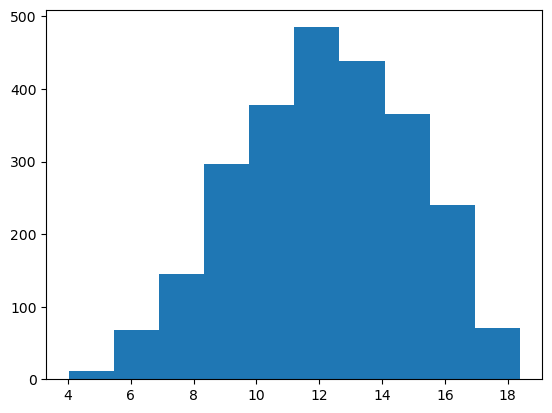

In [13]:
m = 50
gamma = 0.8
print(np.sqrt(2)*((m/2)**gamma), m**gamma)
gens = randomly_draw_generators(m, gamma)
rs = [make_circle(g)[2] for g in gens]
plt.hist(rs)

(array([7.56518588e-01, 3.07415027e-01, 1.79099724e-01, 1.08847942e-01,
        7.07596262e-02, 4.94301695e-02, 3.19941851e-02, 2.94549640e-02,
        1.98059241e-02, 1.79438287e-02, 1.64202960e-02, 1.20189796e-02,
        1.13418540e-02, 7.61766311e-03, 5.92484909e-03, 6.77125610e-03,
        6.09413049e-03, 5.58628628e-03, 5.24772348e-03, 4.40131646e-03,
        4.23203506e-03, 4.06275366e-03, 3.38562805e-03, 1.86209543e-03,
        1.86209543e-03, 3.04706524e-03, 2.03137683e-03, 2.53922104e-03,
        2.20065823e-03, 6.77125610e-04, 2.03137683e-03, 1.69281402e-03,
        1.69281402e-03, 1.01568841e-03, 1.69281402e-03, 1.52353262e-03,
        1.01568841e-03, 1.18496982e-03, 1.01568841e-03, 1.35425122e-03]),
 array([ 1.00020337,  1.59093572,  2.18166806,  2.77240041,  3.36313276,
         3.9538651 ,  4.54459745,  5.13532979,  5.72606214,  6.31679448,
         6.90752683,  7.49825918,  8.08899152,  8.67972387,  9.27045621,
         9.86118856, 10.45192091, 11.04265325, 11.6333856 ,

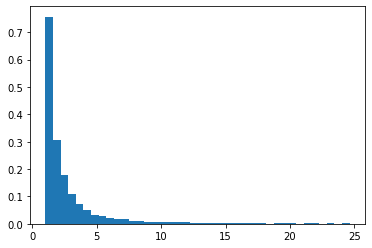

In [6]:
# https://stats.stackexchange.com/questions/508749/generating-random-samples-obeying-the-exponential-distribution-with-a-given-min

a = 4
M = 50
def f(x):
    return a*np.exp(-a*x)
    # return 1 - np.exp(-a*x)
def f_inv(x):
    return -(1/a)*np.log(x/a)

points = []
points_scaled = []
for i in range(10000):
    points.append((M/2)**random.uniform(0,1))
    points_scaled.append((M/2)**f_inv(random.uniform(f(0), f(1))))
    # points_scaled.append(random.uniform(0,1))

# plt.hist(points, bins=20, density=True)
# print(np.mean(points_scaled))
plt.hist(points_scaled, bins=40, density=True)

(array([5.09229051, 0.27985903]), array([[ 1.58343975e-02, -6.65790029e-04],
       [-6.65790029e-04,  2.84759304e-05]]))
(array([0.51133323, 0.52275233]), array([[ 5.82528498e-04, -2.37991289e-04],
       [-2.37991289e-04,  9.82459912e-05]]))


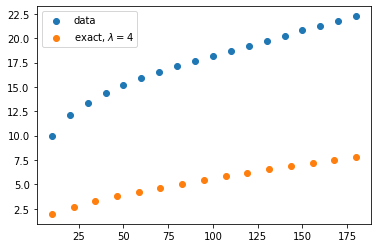

In [127]:
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

def fit_fun(M, c, beta):
    # g(y) is the distribution function
    def g(x):
        # return 1
        l = a
        return (l/(1-np.exp(-l))) * np.exp(-l*x)

    integrand = lambda y: g(y) * (M**y)

    return c * integrate.quad(integrand, 0, 1)[0] * M**((2*beta)-2)

k = 5
beta = 1
type = f"a_{a}"
# type = "uniform"
df = pd.read_csv(f"../results/k_{k}/res_files_dist/{type}/combined_res.res")

tmp_df = df[(df['beta'] == round(beta, 1)) & (df['gamma'] == 0)]
plt.scatter(tmp_df['m'], tmp_df['mean'], label='data')

print(curve_fit(lambda x, c, a: c*x**a, tmp_df['m'], tmp_df['mean']))

xs = np.linspace(10, max(tmp_df['m']), 15)
ys = [fit_fun(x, 1, beta) for x in xs]

plt.scatter(xs, ys, label=f'exact, $\lambda={a}$')
print(curve_fit(lambda x, c, a: c*x**a, xs, ys))

plt.legend()

# plt.savefig(f'../figures/notes4b.png', dpi=600, transparent=False, bbox_inches='tight')


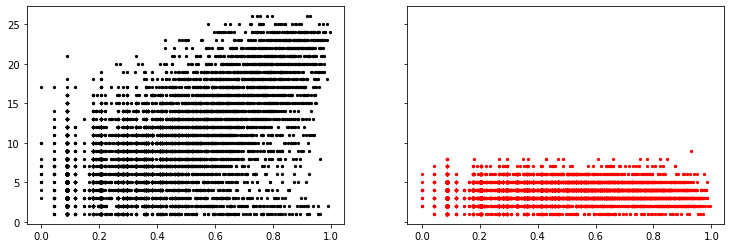

In [166]:
import pandas as pd
fig, ax = plt.subplots(1, 2, figsize=(12.5, 4), sharex=True, sharey=True)


M = 100
df = pd.read_csv("../results/notes/exp2_rounds.csv", names=["radii", "rt_end", "rt_len"])
df.dropna(inplace=True)

df["log_r"] = [math.log(a, M/2) for a in df["radii"].values]
df["rounded_log_r"] = df["log_r"].apply(lambda x: math.floor(x * 10) / 10)
df = df[df["log_r"] < 1]

# plt.xlabel("Generator radius, $\gamma$")
# plt.ylabel("Num rounds to route")
ax[0].scatter(df["log_r"], df["rt_end"], c='k', s=5)
ax[1].scatter(df["log_r"], df["rt_len"], c='r', s=5)

# plt.savefig(f'../figures/notes5.png', dpi=600, transparent=False, bbox_inches='tight')


Text(0, 0.5, 'Num rounds to route')

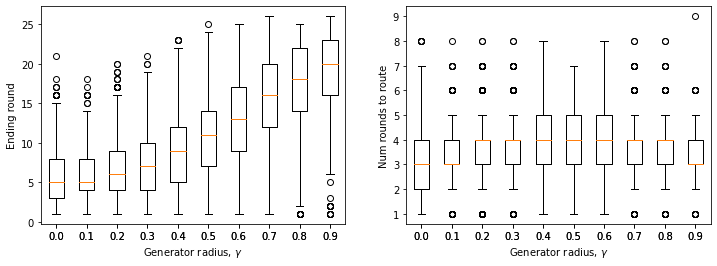

In [167]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)


tmp_dfs_end = []
tmp_dfs_len = []

gammas = sorted(df["rounded_log_r"].unique())
for gamma in gammas:
    tmp_df = df[df["rounded_log_r"] == gamma]
    tmp_dfs_end.append(tmp_df["rt_end"])
    tmp_dfs_len.append(tmp_df["rt_len"])


ax[0].boxplot(tmp_dfs_end, labels=[str(g) for g in gammas])
ax[1].boxplot(tmp_dfs_len, labels=[str(g) for g in gammas])

# plt.bar([str(g) for g in gammas], means, align="center")
# plt.xticks(np.arange(len(gammas)), gammas)
ax[0].set_xlabel('Generator radius, $\gamma$')
ax[0].set_ylabel('Ending round')

ax[1].set_xlabel('Generator radius, $\gamma$')
ax[1].set_ylabel('Num rounds to route')

# plt.savefig(f'../figures/notes10.png', dpi=600, transparent=False, bbox_inches='tight')


Text(0.5, 0, 'Num rounds')

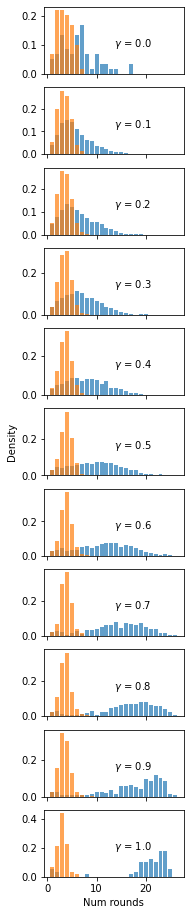

In [130]:
fig, ax = plt.subplots(11, 1, figsize=(2.5, 16), sharex=True, sharey=False)

for i, gamma in enumerate(gammas):
    tmp_df = df[df["rounded_log_r"] == gamma]
    c = Counter(tmp_df["rt_end"])
    ax[i].bar(c.keys(), [v/len(tmp_df) for v in c.values()], label="End", alpha=0.7)

    c = Counter(tmp_df["rt_len"])
    ax[i].bar(c.keys(), [v/len(tmp_df) for v in c.values()], label="Length", alpha=0.7)

    ax[i].text(0.5, 0.4, f"$\gamma$ = {gamma}",transform=ax[i].transAxes)
    # ax[i].set_title(f"$\gamma$ = {gamma}")
ax[5].set_ylabel("Density")
# plt.legend()
ax[-1].set_xlabel("Num rounds")

# plt.savefig(f'../figures/notes10.png', dpi=600, transparent=False, bbox_inches='tight')


In [5]:
# https://math.stackexchange.com/questions/3993770/numerical-integration-solve-upper-bound-given-integral

l = 4
def newtons(p, b0, n):
    # g = lambda x: (l/(1-np.exp(-l))) * np.exp(-l*x)
    g = lambda x: 1
    gint = lambda x: integrate.quad(g, 0, x)[0]

    bn = b0
    for i in range(n):
        bn = bn - (gint(bn)-p)/g(bn)

    return bn

perc = 0.9
cutoff = newtons(perc, 0, 10)
print(cutoff)

0.9


In [6]:
M = 10e4

def g(x):
    return 1
    # return (l/(1-np.exp(-l))) * np.exp(-l*x)

integrand = lambda y: g(y) * (M**y) * M**2


# print(integrate.quad(g, 0, 0.4647706948496652)[0])
# print(1.85*integrate.quad(integrand, 0, 0.4647706948496652)[0] + 6.35)
tot_edges = integrate.quad(integrand, 0, 1)[0]
sm_edges = integrate.quad(integrand, 0, cutoff)[0]
lg_edges = integrate.quad(integrand, cutoff, 1)[0]

print(sm_edges/tot_edges)
print(lg_edges/tot_edges)


0.31622092822612025
0.6837790717738792


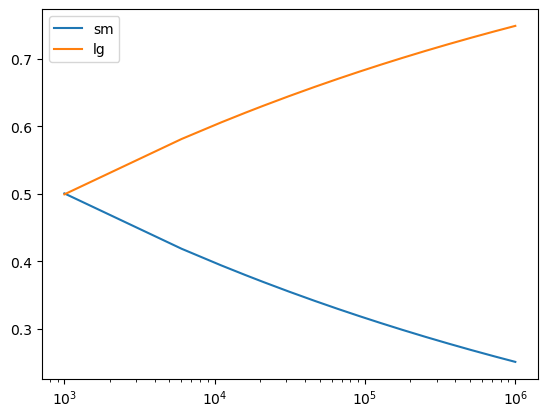

In [8]:
sm = []
lg = []
tot = []
ms = np.linspace(10e2, 10e5, 200)

for M in ms:
    integrand = lambda y: g(y) * (M**y)

    tot.append(integrate.quad(integrand, 0, 1)[0])
    sm.append(integrate.quad(integrand, 0, cutoff)[0])
    lg.append(integrate.quad(integrand, cutoff, 1)[0])


plt.plot(ms, [s/t for s,t in zip(sm, tot)], label='sm')
plt.plot(ms, [s/t for s,t in zip(lg, tot)], label='lg')

# plt.plot(ms, sm, label='sm')
# plt.plot(ms, lg, label='lg')
# plt.plot(ms, np.log(ms))
plt.xscale('log')
plt.legend()

(array([0.11174641, 0.36152896]), array([[ 1.37412822e-08, -2.57344259e-09],
       [-2.57344259e-09,  4.82020578e-10]]))


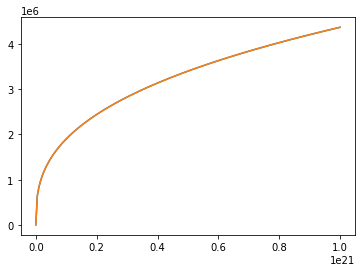

In [109]:
from scipy.optimize import curve_fit

def f(x, c, g):
    return c*x**g

arr = sm
res = curve_fit(f, ms, arr)
print(res)
plt.plot(ms, f(ms, *res[0]))
plt.plot(ms, arr)

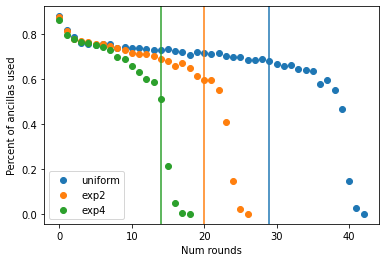

In [124]:
M = 100

ts = ["uniform", "exp2", "exp4"]
cs = ['tab:blue', 'tab:orange', 'tab:green']

for i, t in enumerate(ts):
    df = pd.read_csv(f"../results/notes/{t}_efficiency.csv", names=["round", "used", "available", "perc"])
    df.dropna(inplace=True)

    df2 = pd.read_csv(f"../results/notes/{t}_rounds.csv", names=["radii", "rt_end", "rt_len"])
    df2.dropna(inplace=True)

    df2["log_r"] = [math.log(a, M/2) for a in df2["radii"].values]
    df2["rounded_log_r"] = round(df2["log_r"], 1)

    tmp_dfs_end = []
    tmp_dfs_len = []

    gammas = sorted(df2["rounded_log_r"].unique())
    for gamma in gammas:
        tmp_df = df2[df2["rounded_log_r"] == gamma]
        tmp_dfs_end.append(tmp_df["rt_end"])
        tmp_dfs_len.append(tmp_df["rt_end"] - tmp_df["rt_len"])

    # plt.axvline(x=np.median(tmp_dfs_len[-1]), c='k')
    plt.axvline(x=np.median(tmp_dfs_end[-2]), c=cs[i])
    plt.scatter(df["round"], 1-df["perc"], label=f"{t}")

plt.xlabel("Num rounds")
plt.ylabel("Percent of ancillas used")
plt.legend(loc='lower left')

plt.savefig(f'../figures/notes11.png', dpi=600, transparent=False, bbox_inches='tight')
